In [1]:
import yfinance as yf
import requests
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from scipy.signal import argrelextrema
import matplotlib.colors as mcolors
from matplotlib.transforms import blended_transform_factory

In [2]:
def search_stock_symbol(company_name):
    url = f'https://www.alphavantage.co/query?function=SYMBOL_SEARCH&keywords={company_name}&apikey=Y9DN79N2PBBK2X1O'
    
    # Send request to Alpha Vantage API
    response = requests.get(url)
    data = response.json()
    
    # Extract and print best matches
    if 'bestMatches' in data:
        matches = data['bestMatches']
        for match in matches:
        
            if match['4. region'] == 'India/Bombay':
                symbol = match['1. symbol']
                name = match['2. name']

                return symbol,name

            else:
                continue
    
    else:
        
        raise ValueError("No such company found")

In [3]:
def symbol_changes(symbol):
    symbol = symbol[:-3]
    symbol += "NS"
    
    return symbol

In [4]:
# Calculate EPS and check for -ve growth (quartely-quartely yearly)
def pe_and_market_cap(all_info):
    
    share_price = all_info['currentPrice']
    no_shares = all_info['sharesOutstanding']
    eps = all_info['trailingEps']
    
    market_cap = share_price * no_shares
    pe = market_cap/ (eps * no_shares)
    
    if market_cap < (5000 * (10 **7)):
        Id ='s' #Small Cap

    elif (5000 * (10 ** 7)) < market_cap < 20000 * (10 ** 7):
        Id ='m' #Middle Cap

    else:
           Id ='l' #Large Cap
    
    if Id == 'l':
        id2 = 1
        
    else:
        id2 = 0
    
    return market_cap, pe, id2

In [5]:
def macd(data):
    ma12 = data['Close'].ewm(span=12, adjust=False).mean()
    ma26 = data['Close'].ewm(span=26, adjust=False).mean()
    macd = ma12 - ma26
    signal_line = macd.ewm(span=9, adjust=False).mean()
    
    histogram = macd - signal_line
    
    data["MACD"] = macd
    data['Signal Line'] = signal_line
    data['Histogram'] = histogram
    
    # Calculate slopes for MACD and Signal Line
    data['MACD_slope'] = macd - macd.shift(1)
    data['Signal_slope'] = signal_line - signal_line.shift(1)
    
    # Initialize Signal column
    data['Signal'] = 0
    
    # Define conditions for Buy, Sell, and Hold
    buy_condition = (
        ((data['MACD'] > data['Signal Line']) & (data['MACD'].shift(1) <= data['Signal Line'].shift(1))) |  # Bullish crossover
        ((data['MACD_slope'] > 0) & (data['Signal_slope'] > 0))  # Both lines rising
    )
    
    sell_condition = (
        ((data['MACD'] < data['Signal Line']) & (data['MACD'].shift(1) >= data['Signal Line'].shift(1))) |  # Bearish crossover
        ((data['MACD_slope'] < 0) & (data['Signal_slope'] < 0))  # Both lines falling
    )
    
    # Apply conditions
    data.loc[buy_condition, 'Signal'] = 1
    data.loc[sell_condition, 'Signal'] = -1
    
    # Creating a column for prediction (Buy, Sell, or Hold)
    data['Prediction'] = data['Signal'].apply(lambda x: 'Buy' if x == 1 else ('Sell' if x == -1 else 'Hold'))
    
    return data[['Close', 'MACD', 'Signal Line', 'Histogram', 'MACD_slope', 'Signal_slope', 'Prediction']]

In [6]:
def rsi(data, window=14):
    delta = data['Close'].diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    
    # Calculate initial average gains and losses
    avg_gain = gain[:window].mean()
    avg_loss = loss[:window].mean()
    
    # Initialize RSI values
    rsi_values = []
    
    # Iterate through the rest of the data
    for i in range(window, len(data)):
        avg_gain = (avg_gain * (window - 1) + gain.iloc[i]) / window
        avg_loss = (avg_loss * (window - 1) + loss.iloc[i]) / window
        
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        
        rsi_values.append(rsi)
    
    # Add RSI column to the DataFrame
    data['RSI'] = pd.Series(rsi_values, index=data.index[window:])
    
    return data[window:], window

In [7]:
# # Not giving the right answer
# def lifetime_high(company_name):
    
#     symbol = inp(company_name)
#     comp = yf.Ticker(symbol)
#     data = comp.history(period='1y', interval='1d')
    
#     return round(data['High'].max(), 3)

In [8]:
def fibonacci_retracement(data, window_size=10):
    close_prices = data['Close'].values
    
    # Function to identify trends
    def identify_trend(prices, window):
        trends = np.zeros(len(prices))
        for i in range(window, len(prices)):
            if prices[i] > prices[i-window]:
                trends[i] = 1  # Uptrend
            elif prices[i] < prices[i-window]:
                trends[i] = -1  # Downtrend
        return trends
    
    # Identify trends
    trends = identify_trend(close_prices, window_size)
    
    # Find the most recent significant trend change
    trend_changes = np.diff(trends)
    significant_changes = np.where(np.abs(trend_changes) > 0)[0]
    
    if len(significant_changes) > 0:
        last_change = significant_changes[-1]
        current_trend = "uptrend" if trends[last_change + 1] == 1 else "downtrend"
        
        # Find high and low prices since the trend change
        if current_trend == "uptrend":
            low_price = np.min(close_prices[max(0, last_change-window_size):last_change+1])
            high_price = np.max(close_prices[last_change+1:])
        else:
            high_price = np.max(close_prices[max(0, last_change-window_size):last_change+1])
            low_price = np.min(close_prices[last_change+1:])
    else:
        # If no significant trend change, use the entire dataset
        current_trend = "uptrend" if close_prices[-1] > close_prices[0] else "downtrend"
        high_price = np.max(close_prices)
        low_price = np.min(close_prices)
    
    # Ensure we have valid high and low prices
    if high_price == low_price:
        high_price = np.max(close_prices)
        low_price = np.min(close_prices)
        current_trend = "uptrend" if close_prices[-1] > close_prices[0] else "downtrend"
    
    # Calculate Fibonacci levels
    diff = high_price - low_price
    retracement_levels = {
        "23.6%": high_price - 0.236 * diff if current_trend == "uptrend" else low_price + 0.236 * diff,
        "38.2%": high_price - 0.382 * diff if current_trend == "uptrend" else low_price + 0.382 * diff,
        "50%": high_price - 0.500 * diff if current_trend == "uptrend" else low_price + 0.500 * diff,
        "61.8%": high_price - 0.618 * diff if current_trend == "uptrend" else low_price + 0.618 * diff,
        "78.6%": high_price - 0.786 * diff if current_trend == "uptrend" else low_price + 0.786 * diff
    }
    
    extension_levels = {
        "123.6%": high_price + 0.236 * diff,
        "138.2%": high_price + 0.382 * diff,
        "150%": high_price + 0.500 * diff,
        "161.8%": high_price + 0.618 * diff,
        "200%": high_price + diff,
    }
    
    return {
        "trend": current_trend,
        "prices": {
            "high_price": high_price,
            "low_price": low_price
        },
        "retracement_levels": retracement_levels,
        "extension_levels": extension_levels,
    }

In [9]:
def interpret_macd(data):
    result = ma.iloc[-1]
    
    pred = result['Prediction']
    macd_value = result['MACD']
    signal_value = result['Signal Line']
    histogram = result['Histogram']
    macd_slope = result['MACD_slope']
    signal_slope = result['Signal_slope']
    
    if pred == 'Buy':
        if macd_value > signal_value and macd_slope > 0 and signal_slope > 0:
            macd_response = "Strong Buy: MACD is above Signal Line and both are rising."
            macd_score = 1
        elif macd_value > signal_value:
            macd_response = "Buy: MACD has just crossed above the Signal Line."
            macd_score = 0.5
        else:
            macd_response = "Weak Buy: MACD and Signal Line are rising, but MACD is still below Signal Line."
            macd_score = 0.25
    
    elif pred == 'Sell':
       
        if macd_value < signal_value and macd_slope < 0 and signal_slope < 0:
            macd_response = "Strong Sell: MACD is below Signal Line and both are falling."
            macd_score = -1
        elif macd_value < signal_value:
            macd_response = "Sell: MACD has just crossed below the Signal Line."
            macd_score = -0.5
        else:
            macd_response = "Weak Sell: MACD and Signal Line are falling, but MACD is still above Signal Line."
            macd_score = 0.25
    
    else:  # Hold
        if histogram > 0:
            if macd_slope > 0 and signal_slope > 0:
                macd_response = "Hold (Bullish): MACD is above Signal Line and both are rising, but no crossover yet."
                macd_score = 0.25
            elif macd_slope < 0 and signal_slope < 0:
                macd_response = "Hold (Bearish Divergence): MACD is above Signal Line but both are falling."
                macd_score = -0.25
            else:
                macd_response = "Hold: MACD is above Signal Line but trend is unclear."
                macd_score = 0
        else:
            if macd_slope < 0 and signal_slope < 0:
                macd_response = "Hold (Bearish): MACD is below Signal Line and both are falling, but no crossover yet."
                macd_score = 0.25
            elif macd_slope > 0 and signal_slope > 0:
                macd_response = "Hold (Bullish Divergence): MACD is below Signal Line but both are rising."
                macd_score = 0.25
            else:
                macd_response = "Hold: MACD is below Signal Line but trend is unclear."
                macd_score = 0
    
    return macd_score, macd_response

In [10]:
def analyze_rsi(data):
    rsi_value = data['RSI']
    current_rsi = rsi_value.iloc[-1]
    prev_rsi = rsi_value.iloc[-2]
    rsi_change = current_rsi - prev_rsi

    if current_rsi > 70:
        if rsi_change > 0:
            rsi_score = -1  # Strong Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising, indicating strong overbought conditions. Consider SELLING.'
        else:
            rsi_score = -0.75  # Moderate Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} but decreasing, suggesting potential reversal from overbought conditions. Monitor closely for selling opportunities.'

    elif 70 >= current_rsi > 60:
        if rsi_change > 0:
            rsi_score = -0.5  # Mild Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising towards overbought territory. Consider selling or holding for some more time before selling .'
        else:
            rsi_score = -0.25  # Weak Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} but decreasing, moving away from overbought levels. Hold positions but stay cautious.'

    elif 60 >= current_rsi > 50:
        if rsi_change > 0:
            rsi_score = 0.25  # Weak Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising, showing increasing bullish momentum. Consider BUYING.'
        else:
            rsi_score = -0.25  # Weak Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} but decreasing, indicating weakening bullish momentum. Hold current positions.'

    elif 50 >= current_rsi > 40:
        if rsi_change > 0:
            rsi_score = 0.25  # Weak Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising, showing potential recovery from bearish territory. Monitor for buying opportunities.'
        else:
            rsi_score = -0.25  # Weak Sell
            rsi_response = f'RSI is {round(current_rsi, 2)} and decreasing, moving towards oversold levels. Hold current positions and watch for further decline to buy.'

    elif 40 >= current_rsi > 30:
        if rsi_change > 0:
            rsi_score = 0.5  # Mild Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising from oversold levels. Consider initiating buying.'
        else:
            rsi_score = 0.25  # Weak Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and approaching oversold territory. Prepare for buying opportunities.'

    else:  # RSI <= 30
        if rsi_change > 0:
            rsi_score = 0.75  # Moderate Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and rising from oversold conditions. Strong buying opportunity, but be aware of potential false signals.'
        else:
            rsi_score = 1  # Strong Buy
            rsi_response = f'RSI is {round(current_rsi, 2)} and still decreasing in oversold territory. Very strong buy signal, but confirm with other indicators.'

    return rsi_score, rsi_response

In [11]:
def fib_insight(current_price, levels, trend):
    insights = []
    weight = 0
    
    def get_nearest_levels(price, level_dict):
        sorted_levels = sorted(level_dict.items(), key=lambda x: x[1])
        below = next(((name, value) for name, value in reversed(sorted_levels) if value < price), None)
        above = next(((name, value) for name, value in sorted_levels if value > price), None)
        return below, above

    if trend == 'uptrend':
        #insights.append("Trend: Uptrend")
        below, above = get_nearest_levels(current_price, levels['extension'])
        
        if below and above:
            below_name, below_value = below
            above_name, above_value = above
            progress = (current_price - below_value) / (above_value - below_value)
            insights.append(f"Price is between {below_name} ({round(below_value, 2)}) and {above_name} ({round(above_value, 2)}) extension levels.")
            insights.append(f"Current price has retraced {round(progress * 100, 2)}% of the distance between these levels.")
            
            if progress < 0.2:
                insights.append(f"Price is close to {below_name} level, may act as support. Consider BUYING if it holds.")
                weight += 1
            elif progress > 0.8:
                insights.append(f"Price is approaching {above_name} level, may face resistance. Consider SELLING.")
                weight -= 1
            else:
                insights.append("Price is in the middle of the range. Watch for breakout in either direction.")
        
        for level_name, level_value in levels['extension'].items():
            price_diff_percent = (current_price - level_value) / level_value * 100
            if abs(price_diff_percent) <= 1:  # Within 1% of a level
                insights.append(f"Price is very close to {level_name} extension level ({round(level_value, 2)}), indicating potential resistance. Consider SELLING.")
                weight -= 2
            elif price_diff_percent > 1:  # Above a level
                weight += max(0, 3 - price_diff_percent)  # More weight for levels just broken
            
    elif trend == 'downtrend':
        #insights.append("Trend: Downtrend")
        below, above = get_nearest_levels(current_price, levels['retracement'])
        
        if below and above:
            below_name, below_value = below
            above_name, above_value = above
            progress = (current_price - below_value) / (above_value - below_value)
            insights.append(f"Price is between {below_name} ({round(below_value, 2)}) and {above_name} ({round(above_value, 2)}) retracement levels.")
            insights.append(f"Current price has retraced {round(progress * 100, 2)}% of the distance between these levels.")
            
            if progress < 0.2:
                insights.append(f"Price is close to {below_name} level, may act as support. Consider BUYING if it holds.")
                weight += 1
            elif progress > 0.8:
                insights.append(f"Price is approaching {above_name} level, may face resistance. Consider SELLING if it fails to break.")
                weight -= 1
            else:
                insights.append("Price is in the middle of the range. Watch for breakout in either direction.")
        
        for level_name, level_value in levels['retracement'].items():
            price_diff_percent = (current_price - level_value) / level_value * 100
            if abs(price_diff_percent) <= 1:  # Within 1% of a level
                insights.append(f"Price is very close to {level_name} retracement level ({round(level_value, 2)}), indicating potential support. Consider BUYING.")
                weight += 2
            elif price_diff_percent < -1:  # Below a level
                weight -= max(0, 3 + price_diff_percent)  # More weight for levels just broken

    return insights, weight

In [21]:
def visualise_fib(d, data):
    high = d["prices"]['high_price']
    low = d["prices"]['low_price']
    trend = d["trend"]
    
    retracement_levels = d['retracement_levels']
    extension_levels = d['extension_levels']
    
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(data['Close'], label='Close Price', linewidth=3)
    plt.style.use('classic')
    
    trend_start_date = data.index[data.loc['Close'] == low][0]
    trend_end_date = data.index[data.loc['Close'] == high][0]
    
    ax.axvspan(trend_start_date, trend_end_date, color='yellow', alpha=0.3, label='Trend')
    
    sorted_retracement = sorted(retracement_levels.items(), key=lambda x: float(x[0].strip('%')))
    sorted_extension = sorted(extension_levels.items(), key=lambda x: float(x[0].strip('%')), reverse=True)
    sorted_levels = sorted_extension + sorted_retracement
    
    extension_colors = ['#FF4136', '#FF851B', '#FFDC00', '#2ECC40', '#0074D9']  # Red, Orange, Yellow, Green, Blue
    retracement_colors = ['#B10DC9', '#F012BE', '#85144b', '#001f3f', '#39CCCC']  # Purple, Pink, Maroon, Navy, Teal
    
    colors = extension_colors[:len(extension_levels)] + retracement_colors[:len(retracement_levels)]
    
    for i, (label, level) in enumerate(sorted_levels):
        color = colors[i]
        linestyle = '--' if label in retracement_levels else ':'
        ax.axhline(level, linestyle=linestyle, color=color, linewidth=2)
        ax.plot(data.index[-1], level, 'o', color=color, markersize=6)
    
    ax.set_title('Fibonacci Retracement and Extension Levels', fontsize=16, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Price', fontsize=12)
    
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator())
    
    extra_days = pd.Timedelta(days=20)
    ax.set_xlim(data.index[-180], data.index[-1]+extra_days)
    
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Create a second axes for the labels
    ax2 = ax.twinx()
    ax2.set_ylim(ax.get_ylim())
    ax2.set_yticks([])
    
    label_positions = np.linspace(0.95, 0.05, len(sorted_levels))
    for i, (label, level) in enumerate(sorted_levels):
        color = colors[i]
        ax2.text(1.02, label_positions[i], f'{label} ({round(level, 2)})', 
                 color=color, va='center', ha='left', fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor=color, alpha=1, boxstyle='round,pad=0.3'),
                 transform=ax2.transAxes)
    
    plt.tight_layout()
    plt.show()
    
#     print("Fibonacci Levels:")
#     for label, level in sorted_levels:
#         print(f"{label} level: {round(level, 2)}")`

In [13]:
def visualise_macd(data):
    
    valid_data = data.dropna(subset=['MACD', 'Signal Line'])
    
    fig, ax1 = plt.subplots(1, figsize=(12,8))
    
    plt.style.use('ggplot')
    
    # Change colors to more pleasing options
    macd_color = '#1e90ff'  # Dodger Blue
    signal_color = '#ff6347'  # Tomato
    
    # Plot MACD and Signal lines
    ax1.plot(valid_data.index, valid_data['MACD'], label='MACD', color=macd_color, linewidth=1.5)
    ax1.plot(valid_data.index, valid_data['Signal Line'], label='Signal Line', color=signal_color, linestyle='--', linewidth=1.5)
    
    # Improve histogram appearance using fill_between instead of bar
    histogram = valid_data['MACD'] - valid_data['Signal Line']
    ax1.fill_between(valid_data.index, histogram, 0, where=histogram >= 0, facecolor='#2ecc71', alpha=0.7, interpolate=True, label='Positive Histogram')
    ax1.fill_between(valid_data.index, histogram, 0, where=histogram < 0, facecolor='#e74c3c', alpha=0.7, interpolate=True, label='Negative Histogram')
    
    # Enhance the legend
    ax1.legend(loc='upper left', frameon=True, fancybox=True, shadow=True)
    
    # Improve x-axis
    ax1.xaxis.set_major_locator(mdates.MonthLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    plt.xticks(rotation=45, ha='right')
    
    # Adding extra days
    extra_days = pd.Timedelta(days=20)
    ax1.set_xlim(data.index[0], data.index[-1]+extra_days)
    
    # Set title and labels
    ax1.set_title("MACD Indicator", fontsize=16, fontweight='bold')
    ax1.set_xlabel("Date", fontsize=12)
    ax1.set_ylabel("MACD Value", fontsize=12)
    
    
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    
    plt.show()

In [14]:
def visualise_rsi(data, window):
    # Set the ggplot style for grey background
    plt.style.use('ggplot')
    
    fig, ax2 = plt.subplots(1, figsize=(12, 8))
    
    # Plot the RSI line with Dodger Blue color
    ax2.plot(data.index, data['RSI'], label='RSI', color='dodgerblue', linewidth=2)
    
    # Threshold lines for overbought (70) and oversold (30) with bold colors
    ax2.axhline(70, linestyle='--', color='red', linewidth=2)  # Overbought threshold
    ax2.axhline(30, linestyle='--', color='green', linewidth=2)  # Oversold threshold
    
    # Set axis labels and title with larger font sizes
    ax2.set_title("RSI (Relative Strength Index)", fontsize=16)
    ax2.set_ylabel('RSI Value', fontsize=14)
    ax2.set_xlabel('Date', fontsize=14)
    
    # Customize the ticks on x-axis for months
    ax2.xaxis.set_major_locator(mdates.MonthLocator())
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
    ax2.set_ylim(0, 100)
    extra_days = pd.Timedelta(days=20)
    ax2.set_xlim(data.index[window-2], data.index[-1]+extra_days)
    
    # Remove gridlines
    ax2.grid(False)
    
    # Remove the top and right spines for a cleaner look
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    # Add a legend with a slightly larger font size
    ax2.legend(loc='upper left', fontsize=12)
    
    # Show the plot
    plt.show()


Enter a name: hindustan copper

Sell your stocks of HINDUSTAN COPPER LTD.
Current Price of HINDUSTAN COPPER LTD.: 342.9
Market Cap of HINDUSTAN COPPER LTD.: 33159.25 Crores
The P/E ratio is 92.43, which is above 20, hence SELL


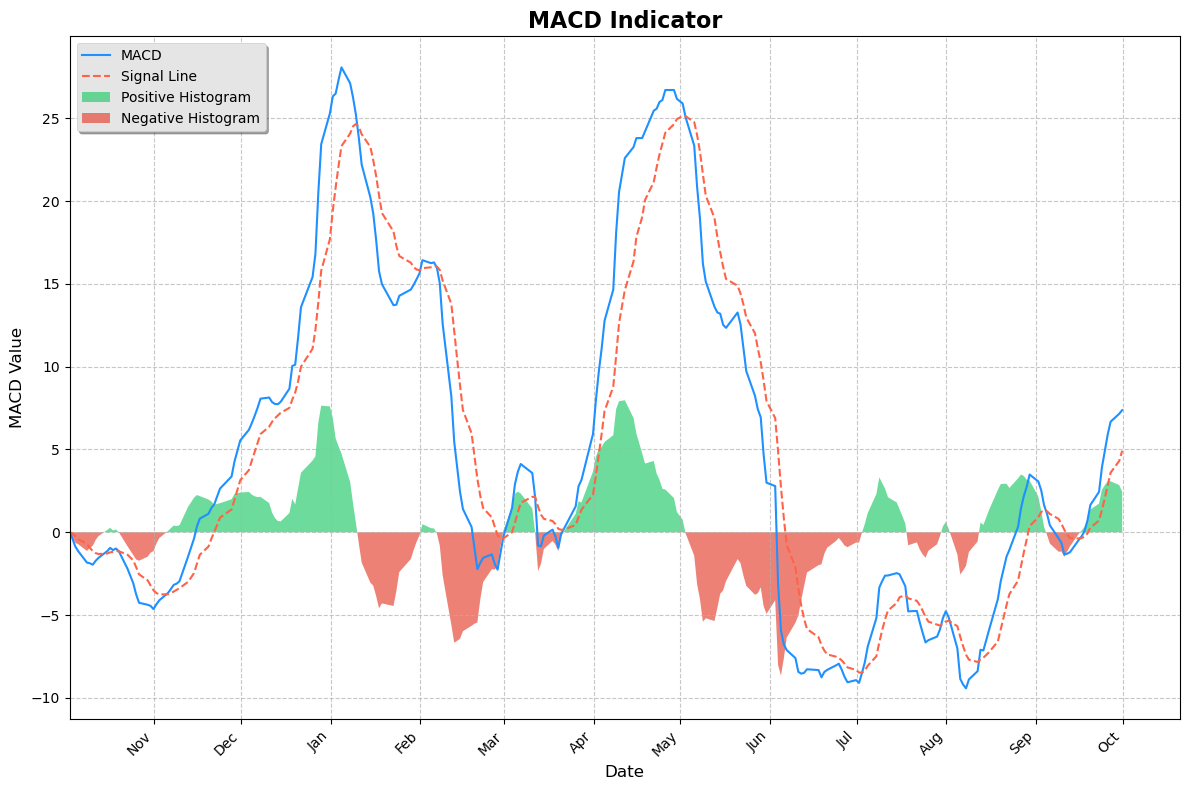

Strong Buy: MACD is above Signal Line and both are rising.


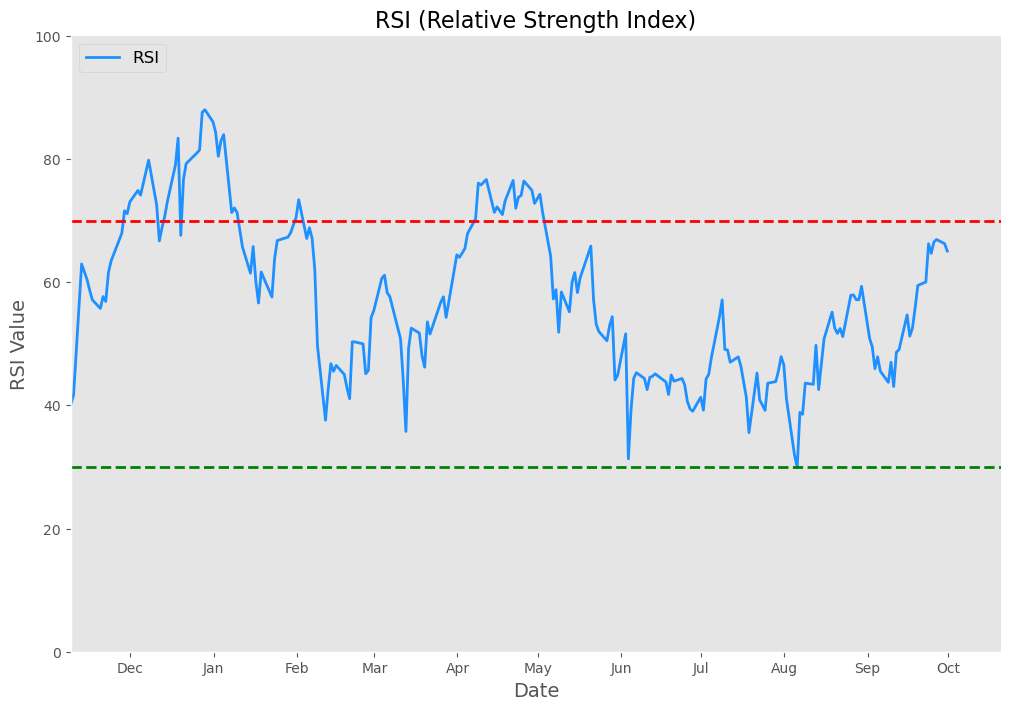

RSI is 65.05 but decreasing, moving away from overbought levels. Hold positions but stay cautious.


KeyError: 'Close'

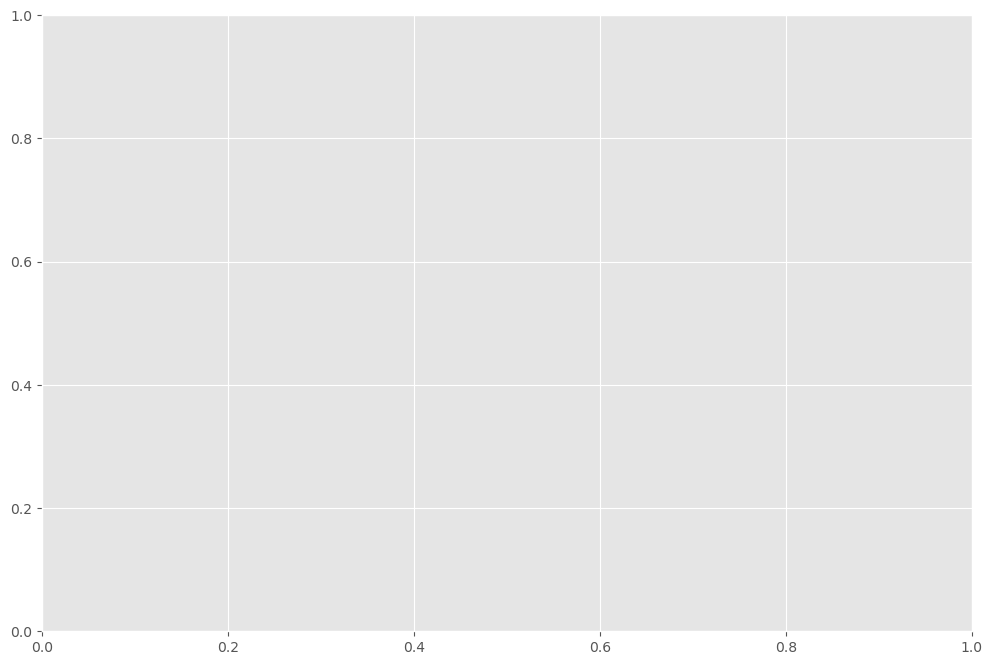

In [16]:
#INPUT
name = input('Enter a name: ')

# PREPROCESSING THE NAME
symbol,st_name = search_stock_symbol(name)
symbol = symbol_changes(symbol)

# API CALL
comp = yf.Ticker(symbol)
data = comp.history(period='1y', interval='1d')
info = comp.info

curr_price = info['currentPrice']

weights = {
    'pe': 0.4,
    'rsi': 0.3,
    'macd': 0.3,
    'fib': 0.3
}

# PE RATIO AND CAP ID
info = pe_and_market_cap(info)

if info[2] != 1:
    print('The company is not large cap')
    
else:
    pe = info[1]
    
    if pe <= 20:
        pe_score = 1  # Buy
        pe_response = f'The P/E ratio is {round(pe,2)}, which is below 20, hence BUY'
    
    else:
        pe_score = -1  # Sell
        pe_response = f'The P/E ratio is {round(pe,2)}, which is above 20, hence SELL'
        
        
    # RSI
    r, window = rsi(data)
    rsi_score, rsi_response = analyze_rsi(r)
    
    # MACD
    ma = macd(data)
    macd_score, macd_response = interpret_macd(ma)
                   
        
    # Fibonacci Retracement
    fib = fibonacci_retracement(data)
    
    current_price = data['Close'].iloc[-1]
    trend = fib['trend']
    
    levels = dict()
    levels['retracement'] = fib['retracement_levels']
    levels ['extension'] = fib['extension_levels'] 
    
    
    fib_response, fib_score = fib_insight(current_price=current_price, trend=trend, levels=levels)
            

final_score = (pe_score * weights['pe']) + (rsi_score * weights['rsi']) + (macd_score * weights['macd']) + (fib_score * weights['fib'])

# Decision based on final score
if final_score > 0:
    print(f'\nBuy stocks of {st_name}')
else:
    print(f'\nSell your stocks of {st_name}')
    

print(f'Current Price of {st_name}: {curr_price}')
print(f'Market Cap of {st_name}: {round(info[0] / (10 ** 7) , 2)} Crores')

print(pe_response)  

visualise_macd(ma)
print(macd_response)

visualise_rsi(r, window)
print(rsi_response)

visualise_fib(fib, data)
print(*fib_response)

In [17]:
def calculate_signal(symbol, data, current_date):
    # Slice the data up to the current date
    current_data = data.loc[:current_date]
    
    # Get the latest info
    comp = yf.Ticker(symbol)
    info = comp.info
    
    curr_price = current_data['Close'].iloc[-1]
    
    weights = {
        'pe': 0.4,
        'rsi': 0.3,
        'macd': 0.3,
        'fib': 0.3
    }
    
    # PE RATIO AND CAP ID
    market_cap, pe, is_large_cap = pe_and_market_cap(info)
    
    if not is_large_cap:
        return 0  # No signal for non-large cap companies
    
    if pe <= 20:
        pe_score = 1  # Buy
    else:
        pe_score = -1  # Sell
    
    # RSI
    r, window = rsi(current_data)
    rsi_score, _ = analyze_rsi(r)
    
    # MACD
    ma = macd(current_data)
    macd_score, _ = interpret_macd(ma)
    
    # Fibonacci Retracement
    fib = fibonacci_retracement(current_data)
    current_price = current_data['Close'].iloc[-1]
    trend = fib['trend']
    levels = {
        'retracement': fib['retracement_levels'],
        'extension': fib['extension_levels']
    }
    _, fib_score = fib_insight(current_price=current_price, trend=trend, levels=levels)
    
    final_score = (pe_score * weights['pe']) + (rsi_score * weights['rsi']) + (macd_score * weights['macd']) + (fib_score * weights['fib'])
    
    return 1 if final_score > 0 else -1

In [18]:
def backtest(symbol):
    # Download data
    stock = yf.Ticker(symbol)
    data = stock.history(period='1y', interval='1d')
    
    # Initialize variables
    position = 0
    balance = 10000  # Starting with $10,000
    shares = 0
    trades = []
    good_trades = 0
    bad_trades = 0
    
    # Iterate through each day
    for i, current_date in enumerate(data.index):
        current_price = data.loc[current_date, 'Close']
        
        if len(data.loc[:current_date]) < 60:  # Skip the first 50 days to have enough data for indicators
            continue
        
        # Get the signal
        signal = calculate_signal(symbol, data, current_date)
        
        # Execute trades
        if signal == 1 and position == 0:  # Buy signal
            shares_to_buy = balance // current_price
            cost = shares_to_buy * current_price
            balance -= cost
            shares += shares_to_buy
            position = 1
            trade_type = 'buy'
            trades.append((trade_type, current_date, current_price, shares_to_buy))
            
            # Check if the buy was good (price goes up in the next 5 days)
            if i + 5 < len(data):
                future_price = data['Close'].iloc[i + 5]
                if future_price > current_price:
                    good_trades += 1
                else:
                    bad_trades += 1
            
        elif signal == -1 and position == 1:  # Sell signal
            balance += shares * current_price
            trade_type = 'sell'
            trades.append((trade_type, current_date, current_price, shares))
            
            # Check if the sell was good (price goes down in the next 5 days)
            if i + 5 < len(data):
                future_price = data['Close'].iloc[i + 5]
                if future_price < current_price:
                    good_trades += 1
                else:
                    bad_trades += 1
            
            shares = 0
            position = 0
    
    # Final value
    final_balance = balance + shares * data['Close'].iloc[-1]
    return_pct = (final_balance - 10000) / 10000 * 100
    
    total_trades = good_trades + bad_trades
    accuracy = (good_trades / total_trades * 100) if total_trades > 0 else 0
    
    return {
        'final_balance': final_balance,
        'return_pct': return_pct,
        'trades': trades,
        'good_trades': good_trades,
        'bad_trades': bad_trades,
        'accuracy': accuracy
    }

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
symbols = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS'] 

results = {}
for symbol in symbols:
    result = backtest(symbol)
    results[symbol] = result

# Analyze results
for symbol, result in results.items():
    print(f"\nResults for {symbol}:")
    print(f"Final Balance: Rs{result['final_balance']:.2f}")
    print(f"Return: {result['return_pct']:.2f}%")
    print(f"Number of trades: {len(result['trades'])}")
    print(f"Good trades: {result['good_trades']}")
    print(f"Bad trades: {result['bad_trades']}")
    print(f"Accuracy: {result['accuracy']:.2f}%")


Results for RELIANCE.NS:
Final Balance: Rs10337.10
Return: 3.37%
Number of trades: 40
Good trades: 18
Bad trades: 22
Accuracy: 45.00%

Results for TCS.NS:
Final Balance: Rs10185.14
Return: 1.85%
Number of trades: 42
Good trades: 22
Bad trades: 18
Accuracy: 55.00%

Results for HDFCBANK.NS:
Final Balance: Rs10013.76
Return: 0.14%
Number of trades: 37
Good trades: 18
Bad trades: 19
Accuracy: 48.65%

Results for INFY.NS:
Final Balance: Rs9833.60
Return: -1.66%
Number of trades: 39
Good trades: 17
Bad trades: 19
Accuracy: 47.22%

Results for HINDUNILVR.NS:
Final Balance: Rs9381.37
Return: -6.19%
Number of trades: 34
Good trades: 18
Bad trades: 16
Accuracy: 52.94%


In [69]:
for trade in results['RELIANCE.NS']['trades']:
            print(f"{trade[0].capitalize()} on {trade[1]}: Price Rs {trade[2]:.2f}, Shares: {trade[3]}")

Buy on 2024-02-29 00:00:00+05:30: Price Rs 2911.72, Shares: 3.0
Sell on 2024-03-01 00:00:00+05:30: Price Rs 2974.16, Shares: 3.0
Buy on 2024-03-07 00:00:00+05:30: Price Rs 2947.85, Shares: 3.0
Sell on 2024-03-11 00:00:00+05:30: Price Rs 2923.28, Shares: 3.0
Buy on 2024-03-12 00:00:00+05:30: Price Rs 2940.87, Shares: 3.0
Sell on 2024-03-13 00:00:00+05:30: Price Rs 2854.66, Shares: 3.0
Buy on 2024-03-18 00:00:00+05:30: Price Rs 2869.21, Shares: 3.0
Sell on 2024-03-19 00:00:00+05:30: Price Rs 2840.86, Shares: 3.0
Buy on 2024-03-21 00:00:00+05:30: Price Rs 2892.13, Shares: 3.0
Sell on 2024-03-22 00:00:00+05:30: Price Rs 2900.21, Shares: 3.0
Buy on 2024-03-26 00:00:00+05:30: Price Rs 2873.40, Shares: 3.0
Sell on 2024-03-27 00:00:00+05:30: Price Rs 2975.60, Shares: 3.0
Buy on 2024-04-15 00:00:00+05:30: Price Rs 2919.74, Shares: 3.0
Sell on 2024-04-22 00:00:00+05:30: Price Rs 2949.69, Shares: 3.0
Buy on 2024-04-25 00:00:00+05:30: Price Rs 2910.07, Shares: 3.0
Sell on 2024-04-26 00:00:00+05:30

In [66]:
for trade in results['TCS.NS']['trades']:
            print(f"{trade[0].capitalize()} on {trade[1]}: Price Rs {trade[2]:.2f}, Shares: {trade[3]}")

Buy on 2024-01-01 00:00:00+05:30: Price Rs 3766.13, Shares: 2.0
Sell on 2024-01-02 00:00:00+05:30: Price Rs 3738.56, Shares: 2.0
Buy on 2024-01-05 00:00:00+05:30: Price Rs 3693.79, Shares: 2.0
Sell on 2024-01-08 00:00:00+05:30: Price Rs 3634.89, Shares: 2.0
Buy on 2024-01-10 00:00:00+05:30: Price Rs 3669.23, Shares: 2.0
Sell on 2024-01-12 00:00:00+05:30: Price Rs 3836.98, Shares: 2.0
Buy on 2024-02-22 00:00:00+05:30: Price Rs 4048.21, Shares: 2.0
Sell on 2024-02-26 00:00:00+05:30: Price Rs 3962.98, Shares: 2.0
Buy on 2024-02-27 00:00:00+05:30: Price Rs 4065.34, Shares: 2.0
Sell on 2024-02-28 00:00:00+05:30: Price Rs 4079.75, Shares: 2.0
Buy on 2024-02-29 00:00:00+05:30: Price Rs 4056.13, Shares: 2.0
Sell on 2024-03-05 00:00:00+05:30: Price Rs 3973.92, Shares: 2.0
Buy on 2024-04-03 00:00:00+05:30: Price Rs 3909.74, Shares: 2.0
Sell on 2024-04-04 00:00:00+05:30: Price Rs 3965.20, Shares: 2.0
Buy on 2024-04-08 00:00:00+05:30: Price Rs 3934.75, Shares: 2.0
Sell on 2024-04-09 00:00:00+05:30